In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
def preprocessing(image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    image = image/255
    return image


features = []
targets = []
for i in ["no","yes"]:
    collectionImageNames = os.listdir("augmented_dataset" +"/" + str(i))
    for j in collectionImageNames:
        img = cv2.imread("augmented_dataset" + "/" + str(i) + "/" + j)
        img = cv2.resize(img,(224,224))
        features.append(img)
        if i == "no":
            targets.append(0)
        elif i == "yes":
            targets.append(1)
    print("Loading in folder", i)

Loading in folder no
Loading in folder yes


In [5]:
targets.count(1)

894

In [6]:
targets.count(0)

574

In [23]:
features = np.array(features)
targets = np.array(targets)

In [9]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [26]:
features.shape


(1468, 150528)

In [25]:
features = features.reshape(1468,224*224*3)

In [27]:
oversample = RandomOverSampler(sampling_strategy='minority')
features_f,target_f = oversample.fit_resample(features,targets)

In [43]:
features.shape

(1468, 224, 224, 3)

In [44]:
features_f.shape


(1788, 150528)

In [55]:
features_f.shape

(1788, 224, 224, 3)

In [54]:
features_f = features_f.reshape(1788,224,224,3)

In [29]:
features = features.reshape(1468,224,224,3)

In [56]:
train_features, test_features, train_target, test_target = train_test_split(features_f, target_f, test_size=0.2)

In [57]:
print("The training features and target shapes are {} and {} :".format(train_features.shape,train_target.shape))

The training features and target shapes are (1430, 224, 224, 3) and (1430,) :


In [58]:
print("The testing featuers and target shape are: {} and {}".format(test_features.shape,test_target.shape))

The testing featuers and target shape are: (358, 224, 224, 3) and (358,)


In [59]:
train_features = np.array(list(map(preprocessing, train_features)))
test_features = np.array(list(map(preprocessing, test_features)))

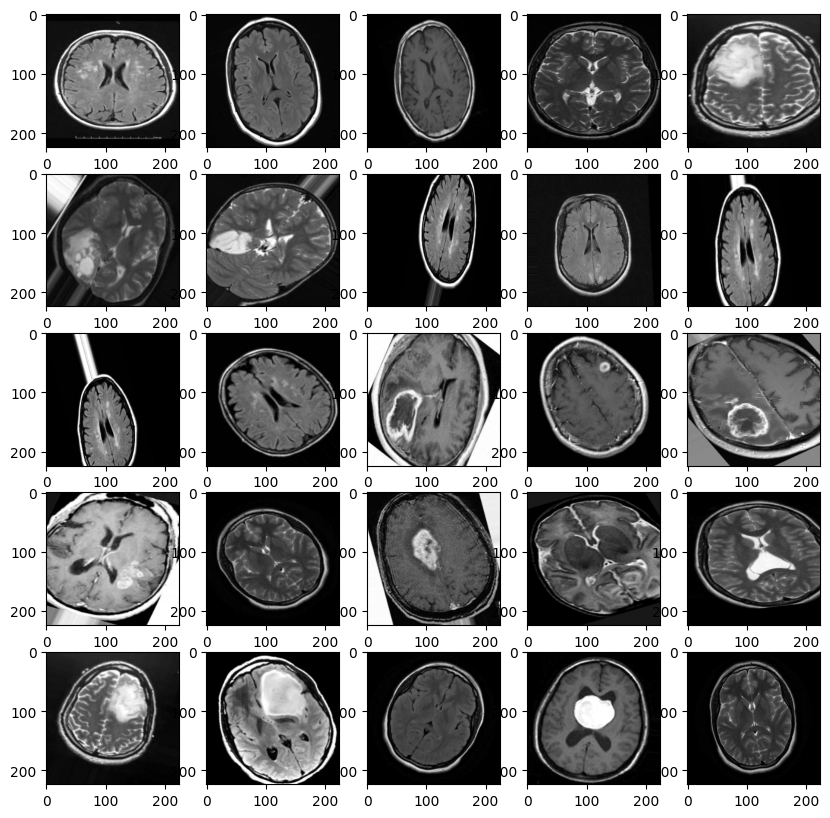

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in list(range(25)):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_features[i],cmap='gray')
plt.show()

In [61]:
print(train_features.shape)
print(test_features.shape)

(1430, 224, 224)
(358, 224, 224)


In [63]:
train_features = train_features.reshape(1430, 224, 224, 1)
test_features = test_features.reshape(358, 224, 224, 1)


In [64]:
print(train_features.shape)
print(test_features.shape)

(1430, 224, 224, 1)
(358, 224, 224, 1)


In [65]:
DataGen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.2)
DataGen.fit(train_features)
batches = DataGen.flow(train_features, train_target, batch_size=20)
train_target = to_categorical(train_target)


In [66]:
# step 1------ Specify the architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(2, activation="softmax"))


In [67]:
model.build()

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                  

In [69]:
#Step 2----- Compile the model
model.compile(Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [78]:
# Step 3-----Train the model
fitting = model.fit(DataGen.flow(train_features, train_target, batch_size=32), epochs=1)

45/45 [==============================] - 95s 2s/step - loss: 0.1966 - accuracy: 0.9336


In [79]:
predictions = np.argmax(model.predict(test_features),axis=1)

12/12 [==============================] - 4s 334ms/step


In [80]:
count = 0
for i in range(len(test_target)):
    if predictions[i] == test_target[i]:
        count+=1
print(count)
print("The accuracy is " ,count/len(test_target)*100)

329
The accuracy is  91.89944134078212


In [76]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_target, predictions)
print(matrix)

[[152  13]
 [ 17 176]]


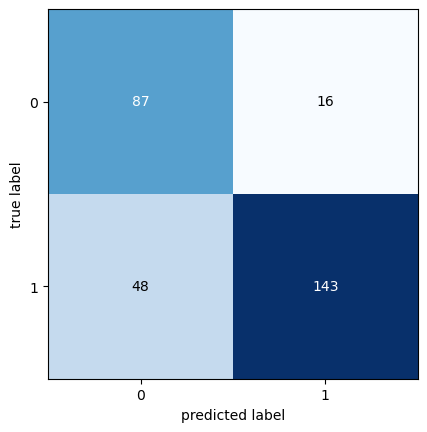

In [22]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(matrix)
plt.show()

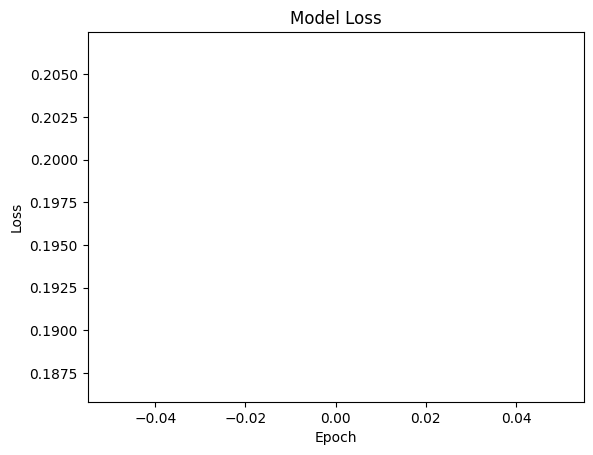

In [81]:
plt.plot(fitting.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

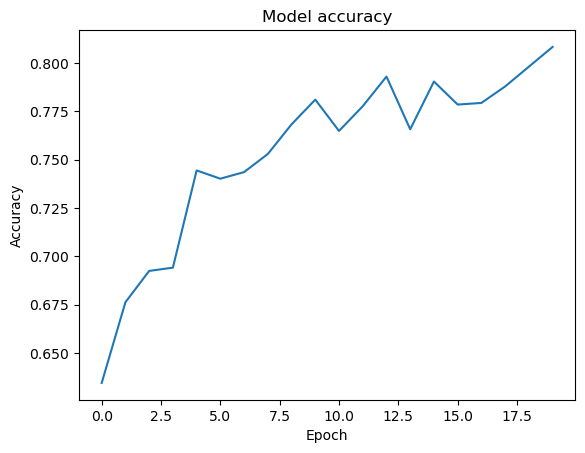

In [24]:
plt.plot(fitting.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

12/12 [==============================] - 4s 321ms/step


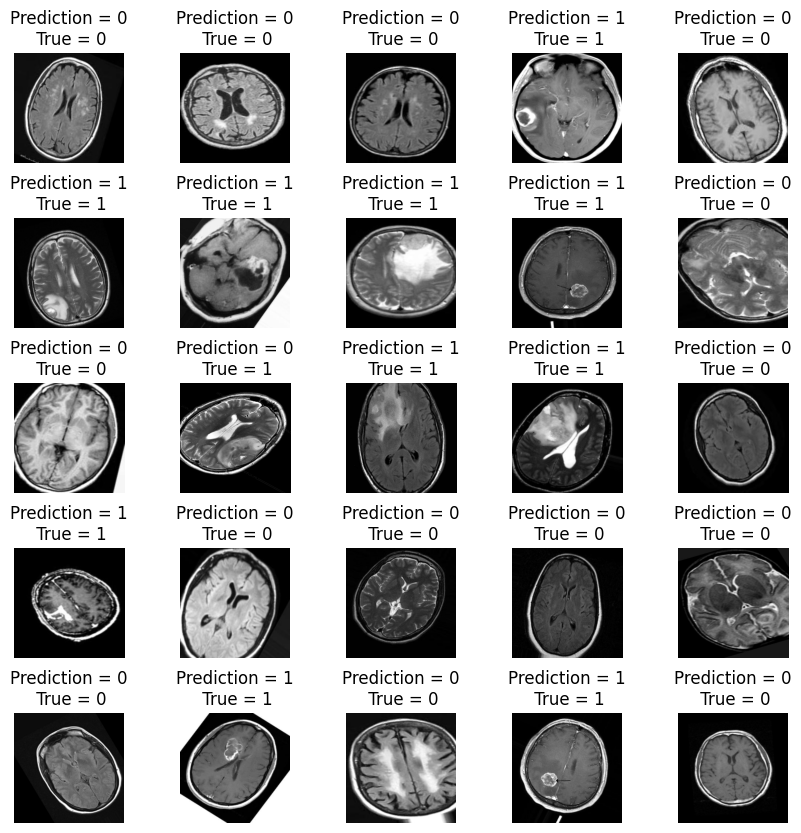

In [82]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()
y_pred = model.predict(test_features)
for i in np.arange(0,L*W):
    axes[i].imshow(test_features[i],cmap='gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], test_target[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5, hspace=0.5) 

In [84]:
model.save("CNN")

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets
